# Hematopoietic Lineage Predictor

## Load data

In [16]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'df_discovery.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'df_validation.pkl').sort_index()

# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=0)

## Preprocess data

### Exclude samples with missing labels

In [17]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df = df[~df['Hematopoietic Lineage'].isna()]

df['Hematopoietic Lineage'].value_counts(dropna=False)

Hematopoietic Lineage
Acute myeloid leukemia (AML)                  1217
Acute lymphoblastic leukemia (ALL)             905
Myelodysplastic syndrome (MDS or MDS-like)     157
Otherwise-Normal (Control)                     140
Mixed phenotype acute leukemia (MPAL)           51
Acute promyelocytic leukemia (APL)              31
Name: count, dtype: int64

### Define X and y

In [11]:

# Define X and y
X = df[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']].to_numpy() # shape (n_samples=2501, n_features=5)
y = df['Hematopoietic Lineage'].to_numpy() # shape (n_samples=2501,) with 6 string classes

# Split the data into train/test sets based on the `Train Test` column
X_train = X[df['Train Test']=='Discovery (train) Samples']
y_train = y[df['Train Test']=='Discovery (train) Samples']
X_test = X[df['Train Test']=='Validation (test) Samples']
y_test = y[df['Train Test']=='Validation (test) Samples']

## Gaussian Process

In [8]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Fit/predict
gpc = GaussianProcessClassifier(multi_class='one_vs_rest', random_state=42, n_jobs=-1)
_ = gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)
y_pred_proba = gpc.predict_proba(X_test)

# Evaluate
from sklearn.metrics import accuracy_score

print(f'Overall accuracy score: {accuracy_score(y_test, y_pred):.3f}')

Overall accuracy score: 0.917


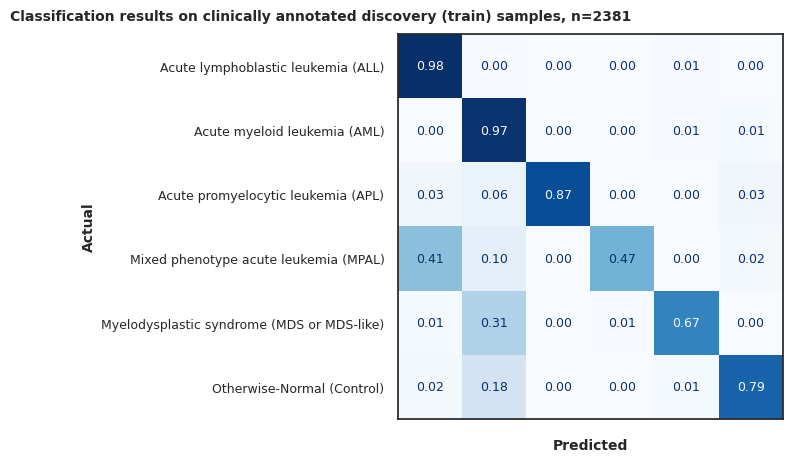

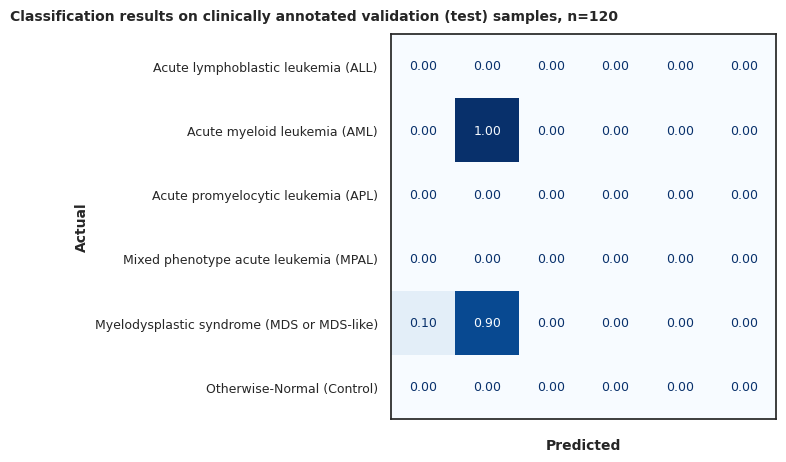

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(clf, x_test, y_test, title='Classification results', tick_fontsize=10, label_fontsize=10):
    sns.set_theme(style='white')
    predictions = clf.predict(x_test)
    cm = confusion_matrix(y_test, predictions, labels=clf.classes_, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=clf.classes_)
    disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical', colorbar=False)

    # Decrease the font size of the numbers inside the confusion matrix
    for texts in disp.text_:
        for text in texts:
            text.set_fontsize(label_fontsize)

    # Decrease the font size of the tick labels
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    # Increase the size of the plot
    fig = plt.gcf()
    fig.set_size_inches(5, 5)

    # Add title and axis names and place title in the middle
    plt.title(title +', n=' + str(len(x_test)), fontsize=10, fontweight='bold', pad=10, x=-0.2)
    plt.xlabel('Predicted', fontsize=10, fontweight='bold')
    plt.ylabel('Actual', fontsize=10, fontweight='bold')

    # remove x tick labels
    plt.gca().axes.xaxis.set_ticklabels([])

    plt.show()

plot_confusion_matrix(gpc, X_train, y_train, tick_fontsize=9, label_fontsize=9, title='Classification results on clinically annotated discovery (train) samples')
plot_confusion_matrix(gpc, X_test, y_test, tick_fontsize=9, label_fontsize=9, title='Classification results on clinically annotated validation (test) samples')
